# Processing Behan 2019
Processing genomewide screen from [Behan et al. 2019](https://www.nature.com/articles/s41586-019-1103-9)

Library Description (from [Tzelepis et al. 2016](https://www.sciencedirect.com/science/article/pii/S2211124716313353?via%3Dihub)):
- sgRNAs that contain BbsI sites or RNA polIII terminator sequences
(a stretch of 5 Ts) were removed

Design scores were calculated using:
- Off-target score up to 4 mismatches
- Population frequency of SNVs
- The number of thymidine in the last 5 nucleotides of gRNAs
These scores were used to rank guides as well as a filter for:
- Cut within first 50% of CDS
- sgRNAs are 19mers

### Data Filters
1. sgRNAs targetting essential genes
2. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

In [2]:
lfc_df = (pd.read_csv('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/depmap-data/Sanger_logfold_change.csv')
          .rename({'Unnamed: 0': 'sgRNA Sequence'}, axis = 1))
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])

In [3]:
lfc_df.head()

,sgRNA Sequence,A375_C902R1_P1D14,A375_C902R2_P1D14,A375_C902R3_P1D14,A375_c902R4,A375_c902R5,A375_c902R6,HCT15_C902R1_P1D14,HCT15_C902R2_P1D14,HCT15_C902R3_P1D14,...,U87MG_c907R1,U87MG_c907R2,YH13_c907R1,YH13_c907R2,42MGBA_c907R1,D423MG_c907R2,IM95_c908R3,MB468_c903R1,MDST8_c903R3,H1355_c906R1
0,TGCTGACGGGTGACACCCA,-0.444600,-0.276138,-0.057663,-0.541072,-0.071765,-0.695229,-0.085053,0.264002,0.259816,...,-0.225926,0.026574,-1.313162,-1.069462,0.488873,0.783022,-0.201151,-0.148249,-0.248523,0.189000
1,CGGGGGTGATCCAGGACAC,-0.020740,-0.611378,-1.414895,-1.807052,-2.152175,-1.708735,-0.258522,-0.923063,-0.008718,...,-1.067254,-0.765637,-2.655998,-0.585938,-0.045499,-0.284598,-0.760816,-1.335831,-0.206019,-0.544817
2,TCAATGGTCACAGTAGCGC,-1.043736,-0.080388,-0.400068,-0.411110,-0.260814,-0.844181,-0.408449,0.186126,0.696627,...,-0.328129,-0.056960,-0.262694,0.821323,0.694319,-0.304142,0.297295,-0.024532,0.603552,0.172283
3,CTGCAGCTACCGGACCGAT,-0.683100,-1.875381,-0.031775,0.075724,-0.097130,-0.166647,0.654378,0.361177,0.549737,...,0.596519,-0.139874,-0.069618,-0.754001,1.152523,0.295116,0.707195,0.646991,0.077764,0.723708
4,GACTTCCAGCTACGGCGCG,-0.159297,0.215882,0.103813,0.854609,-0.055874,0.256792,-0.142789,0.119887,0.439665,...,-0.154073,-0.220981,-1.048998,-1.781727,0.396143,0.107738,-0.579812,0.112121,-0.282696,-0.469201


In [4]:
lfc_df.columns.str.contains('_').sum()

910

In [5]:
condition_sep = '_'

In [6]:
lfc_cors = lfc_df.corr()
long_cors = (lfc_cors.reset_index()
             .rename({'index': 'condition A rep'}, axis=1)
             .melt(var_name='condition B rep', value_name='pearson', id_vars='condition A rep'))
long_cors['condition A'] = long_cors['condition A rep'].str.split(condition_sep, expand=True)[0]
long_cors['condition B'] = long_cors['condition B rep'].str.split(condition_sep, expand=True)[0]
filtered_cors = long_cors[(long_cors['condition A rep'] != long_cors['condition B rep']) &
                          (long_cors['condition A'] == long_cors['condition B'])].copy()
filtered_cors['pearson'].mean()

0.6155398017523642

In [7]:
all_designs = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet')

In [8]:
sg_list = list(lfc_df['sgRNA Sequence'].unique())
all_designs['19mer'] = all_designs['sgRNA Sequence'].str[1:]
design_df = (all_designs[all_designs['19mer'].isin(sg_list)]
             .reset_index(drop=True))

In [9]:
long_lfcs = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence',
                                        condition_indices=[0], sep=condition_sep)

In [10]:
design_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 'Target Cut %', 'On-Target Efficacy Score']

In [11]:
lfcs_designs = (long_lfcs.rename({'sgRNA Sequence': '19mer'}, axis=1)
                .merge(design_df[design_cols + ['19mer', '# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on='19mer')
                .drop('19mer', axis=1))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.gene,
                                fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
39,CO678,0.682639
182,LS123,0.688277
107,HCC15,0.723650
194,MB453,0.734037
303,T84,0.743544
...,...,...
316,TYKnu,0.898963
150,KON,0.900609
236,OVR8,0.906134
29,CAL27,0.908942


In [12]:
roc_aucs['ROC-AUC'].mean()

0.8389772115032015

In [13]:
roc_aucs.shape

(324, 2)

In [14]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.gene)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())))
sg_avg_rank = (filtered_sgs.groupby(design_cols)
               .agg(avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'))
               .reset_index())

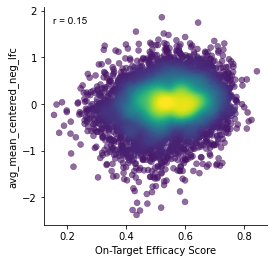

In [15]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_rank, y='avg_mean_centered_neg_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_rank, y='avg_mean_centered_neg_lfc', x='On-Target Efficacy Score', method='spearman')
sns.despine()

In [16]:
training_data = sg_avg_rank.drop(['On-Target Efficacy Score'], axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc
0,AAAAACCTGGTCATGAACAC,ACTGAAAAACCTGGTCATGAACACTGGACC,RPP40,16.9,0.392439
1,AAAAAGATCATGATTGAGCG,ATGTAAAAAGATCATGATTGAGCGGGGAGA,EIF2B1,30.9,0.312222
2,AAAAATAGTTGTAGAGACGC,TCATAAAAATAGTTGTAGAGACGCAGGATG,AURKB,40.2,-0.146409
3,AAAAATTGTAGGGCGCACCA,TGCCAAAAATTGTAGGGCGCACCAAGGATG,NCAPG,21.3,0.563045
4,AAAACGGTAATATCGCCGTG,TTTGAAAACGGTAATATCGCCGTGTGGCAG,GTF3C4,34.8,-0.160358
...,...,...,...,...,...
7437,TTTTTCAGTTGTTGTGGTGC,TGGATTTTTCAGTTGTTGTGGTGCTGGGAC,PSMB7,31.5,-1.571472
7438,TTTTTCGAAGTACATGGCCC,CTTCTTTTTCGAAGTACATGGCCCAGGCAC,LSG1,34.2,0.480396
7439,TTTTTCTTCCAGAAAAATCC,TTCTTTTTTCTTCCAGAAAAATCCTGGGTA,TMEM41B,14.4,-0.373971
7440,TTTTTGCACTAGCCTGAATA,TATTTTTTTGCACTAGCCTGAATAGGGCTA,BORA,50.6,-0.597036


In [19]:
lfcs_designs.to_csv('../data/interim/Behan2019_condition_lfcs.csv', index=False)
training_data.to_csv('../data/processed/Behan2019_activity.csv', index=False)